In [60]:
import numpy as np
import pandas as pd
import glob
import os 
import re
import h5py
import astropy.units as u
import matplotlib.pyplot as plt
from hzlc_result import read_output
from importlib import reload  
import importlib
import astropy.units as u 
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import hzlc_result
importlib.reload(hzlc_result)
date =  20191224
name = "Gaia-DR2_3398180156118506240" 
source_name = name.replace("Gaia-DR2_", "")
catalog_import = "/blacksmith/catalog/used_now/ohsawa_+_mdwarf+wd.pickle"


In [61]:
## star information
catalog_all = pd.read_pickle(catalog_import)
flag = catalog_all["source_id"] == int(source_name)
print(catalog_all[flag])

        Unnamed: 0            source_id         ra        dec  catalog_mag  \
439892   1441284.0  3398180156118506240  87.648502  18.068538      16.1486   

          Teff       rad      mass catalog_name  is_target  \
439892  3032.0  0.264049  0.236216     Gaia-DR2       True   

        is_Mdwarf_0.3-0.4Msun  is_Mdwarf_less_0.3Msun  
439892                  False                    True  


In [62]:
## Nearby stars information from Gaia archive
see_gaia_mem = True
if see_gaia_mem:
    coord = SkyCoord(ra=catalog_all[flag]["ra"].values[0], dec=catalog_all[flag]["dec"].values[0], unit=(u.degree, u.degree), frame='icrs')
    radius = u.Quantity(100.0, u.arcsec)
    j = Gaia.cone_search_async(coord, radius)
    r = j.get_results()
    print("dist (arcsec) = %f" % (1/3600))
    print(r["source_id", "phot_g_mean_mag","dist"])

INFO: Query finished. [astroquery.utils.tap.core]
dist (arcsec) = 0.000278
     source_id      phot_g_mean_mag          dist        
                          mag                            
------------------- --------------- ---------------------
3398180156118506240       16.148636 0.0004752513716505629
3398180254900365056       18.552118  0.005394032443864027
3398180151821117952        16.32635  0.006575609817615232
3398180259195782912       20.395422  0.007583740140580177
3398180259196083200       20.717245  0.007694923713467219
3398180259197716736       19.745077  0.008367338158983996
3398180156118510464       15.475782  0.008906929869697232
3398180151821118848       18.634335  0.009103360182620744
3398181010814624256       20.122095  0.009497414445973951
3398180151821107712       19.231237  0.010709992401574737
                ...             ...                   ...
3398181079534131328       17.888807   0.01985715627704648
3398180980750292864        20.84087  0.0199285539253773

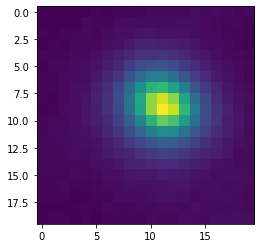

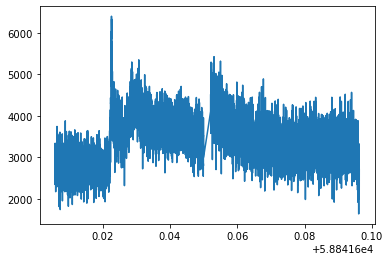

In [63]:
from astropy.time import Time
import lightkurve
import astropy.units as u

## lc & movie load
analysed_movie_file = "/blacksmith/product/out_analysis_%d/movie/movie_%s.hdf5" % (date, name)
dates, dfs_utc, movie_data_catalog_position, movie_data_centroid = read_output.read_movie_hdf5(analysed_movie_file)
images_now = movie_data_catalog_position[0]
t = Time(dfs_utc[0]["utc_frame"], format='datetime64', scale='utc')
times = t.to_value('mjd','long')
times_mv = t.to_value('mjd','long')
analysed_lc_dir = "/blacksmith/product/out_analysis_%d/light_curve_pca" % date 
file_name = os.path.join(analysed_lc_dir, "light_curve_" + name + ".hdf5")
df = read_output.read_LC_hdf5(file_name, date=date)
times_mask, fluxes_mask, flux_errs_mask, flux_pca_mask, mask_lc = read_output.lc_load_from_hdf5(df, plot_flux_name =  "flux_catalog_aperture_r7") 
lc = lightkurve.LightCurve(time = times_mask * 24 * 3600 * u.second , flux = flux_pca_mask)
pg = lc.to_periodogram(oversample_factor=10, freq_unit = "1/s")

## lc & image plot
plt.imshow(np.sum(images_now, axis=0))
plt.show()

plt.plot(times_mask,  flux_pca_mask)
plt.show()

## Lomb scargle
#pg.plot(view='period', scale='log')
#plt.show()
#new_period = pg.period_at_max_power
#print(new_period)
#lc.fold(new_period).bin(0.2 * u.second).scatter(label=rf'Period = {new_period.value:.5f} s');


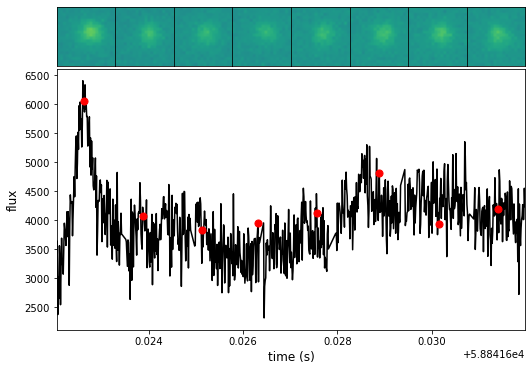

In [66]:
from hzlc_result import detail_plotter
importlib.reload(detail_plotter)

make_detail_plot = True
day_to_second = 3600*24
time_consider =  np.array([58841.622, 58841.632]) #* day_to_second 
t_int = 10 

if make_detail_plot:
    detail_plotter.make_lc_plot_and_snapshot(times_mask , flux_pca_mask, images_now[mask_lc], 8,time_consider, t_int = t_int)

Gaia-DR2_3398180156118506240


Loading BokehJS ...

Gaia-DR2_3398180151821117952


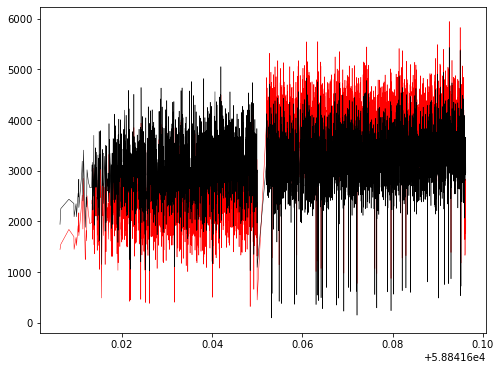

Gaia-DR2_3398181289989868032


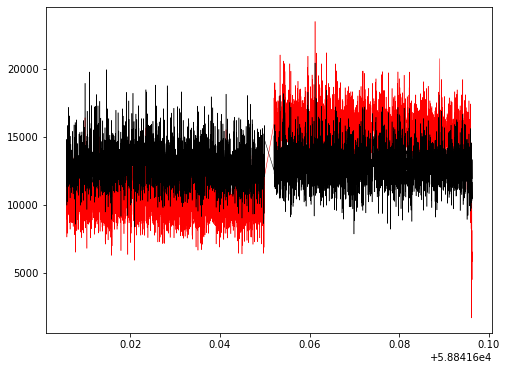

Gaia-DR2_3398179881240597632


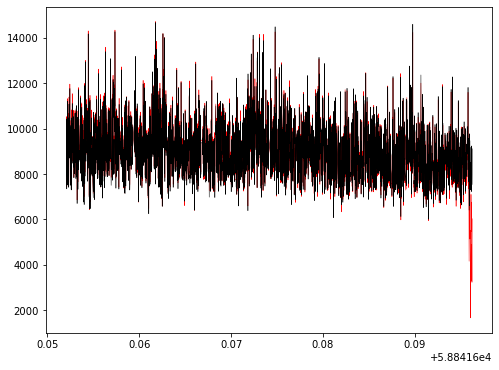

Gaia-DR2_3398181358709345920


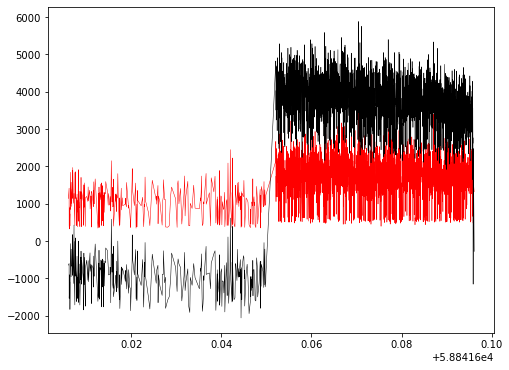

In [67]:
from bokeh.plotting import figure, output_file, show, reset_output, output_notebook
from IPython.display import HTML

dir_catalog_star = "/blacksmith/product/out_analysis_%d/catalog_star_header/" % date
analysed_lc_dir = "/blacksmith/product/out_analysis_%d/light_curve_pca" % date 
max_sep = 500
num_star = 5
source_id_near, mag_near, sep_near, ra_near, dec_near = read_output.take_nearby_stars(catalog_all[flag]["ra"].values[0], catalog_all[flag]["dec"].values[0], max_sep, dir_catalog_star, date)
for (i, source_id) in enumerate(source_id_near[:num_star]):
    if i==0 and "EPIC" in name:
        name_now = "K2-EPIC_%d" % source_id
        plot_name = "K2-EPIC_%d (sep:%.1f)" % (source_id,  sep_near[i])
    else:
        name_now  = "Gaia-DR2_%d" % source_id
        plot_name = "Gaia-DR2_%d (sep:%.1f)" % (source_id,  sep_near[i])    
    print(name_now)
    file_name = os.path.join(analysed_lc_dir, "light_curve_" + name_now + ".hdf5")
    df = read_output.read_LC_hdf5(file_name, date=date)
    times_plot, fluxes_plot, flux_errs_plot, flux_pca_plot, mask = read_output.lc_load_from_hdf5(df, plot_flux_name =  "flux_auto") 
    if i==0:
        read_output.plot_bokeh(times_plot, flux_pca_plot, fluxes_plot, "Aperture", title= plot_name  )
    else:
        plt.figure(figsize = (8, 6))
        plt.plot(times_plot, fluxes_plot, color="r", label="raw", lw = 0.5)  
        plt.plot(times_plot, flux_pca_plot, color="k", label="pca", lw = 0.5)
        plt.show()

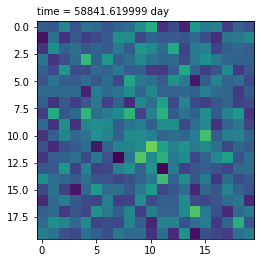

In [76]:
# show movie

make_movie = True
time_consider =  np.array([58841.61, 58841.62])
time_window = (times >time_consider[0]) * (times <time_consider[1])

if make_movie:
    detail_plotter.make_movie(images_now,  times_mask, time_consider)